In this post, let's try to solve the Christoffel equation for wave polarizations.

We need:

- a cij matrix
- a wave vector direction

This allows us to write the following:

$$
\sum_{ij} \left[ M_{ij} - \rho\omega^2 \delta_{ij} \right] s_j = 0
$$

where 
$$
M_{ij} = \sum_{nm} q_n C_{inmj} q_m
$$

In [1]:
import numpy as np

def assemble_christoffel_matrix(cijkl, q):
    M = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            for n in range(3):
                for m in range(3):
                    M[i, j] += q[n] * cijkl[i, n, m, j] * q[m]
    return M

def from_isotropic_lambda_mu(lambd, mu):
    r"""Makes cij for isotropic material given :math:`\lambda` and :math:`\mu` (Lamé's coefficients)."""
    cij = np.zeros((6, 6))
    cij[(0, 1, 2), (0, 1, 2)] = lambd + 2 * mu
    cij[(0, 0, 1, 1, 2, 2), (1, 2, 0, 2, 0, 1)] = lambd
    cij[(3, 4, 5), (3, 4, 5)] = mu
    return cij


def to_cijkl(cij):
    """Converts the Voigt-notation cij to a 4th order tensor cijkl."""
    coord_mapping = {(1, 1): 1,
                     (2, 2): 2,
                     (3, 3): 3,
                     (2, 3): 4,
                     (1, 3): 5,
                     (1, 2): 6,
                     (2, 1): 6,
                     (3, 1): 5,
                     (3, 2): 4}

    cijkl = np.zeros((3, 3, 3, 3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    u = coord_mapping[(i + 1, j + 1)]
                    v = coord_mapping[(k + 1, l + 1)]
                    cijkl[i, j, k, l] = cij[u - 1, v - 1]
    return cijkl

In [2]:
cij = from_isotropic_lambda_mu(115., 77.)
cijkl = to_cijkl(cij)

q = np.array([0., 0., 1.])
assemble_christoffel_matrix(cijkl, q)

array([[ 77.,   0.,   0.],
       [  0.,  77.,   0.],
       [  0.,   0., 269.]])

Now, we only need to solve the equation by injecting a $\rho$  and $\omega$.

In [3]:
rho, omega = 7.8, 1.

M = assemble_christoffel_matrix(cijkl, q)

w, v = np.linalg.eig(M/rho)

w, v

(array([ 9.87179487,  9.87179487, 34.48717949]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]))

As we can see, we find the classical isotropic velocities:

In [4]:
np.sqrt(w)

array([3.14194126, 3.14194126, 5.87257861])

As well as the polarisations: two transverse and one longitudinal wave.

# Velocity curves 

Let's do some classical velocity plots. We define a set of directions in a 2D plane and then compute the associated speeds, which we plot in a polar diagram.

In [17]:
def compute_velocities(qs, cijkl, rho):
    velocities = []
    for q in qs.T:
        M = assemble_christoffel_matrix(cijkl, q)
        w, v = np.linalg.eig(M/rho)
        velocities.append(np.sort(np.sqrt(w)))
    velocities = np.array(velocities)
    return velocities

thetas = np.linspace(0, 2 * np.pi, num=500)

qs = np.c_[[np.cos(thetas), np.sin(thetas), np.zeros_like(thetas)]] 

velocities = compute_velocities(qs, cijkl, rho)

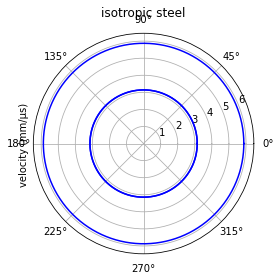

In [18]:
import matplotlib.pyplot as plt

def plot_velocity(thetas, velocities, title=''):
    fig = plt.figure()
    ax = fig.add_subplot('111', projection='polar')
    ax.plot(thetas, velocities, 'b-', ms=.7)
    ax.set_ylabel('velocity (mm/µs)')
    ax.set_title(title)
    ax.set_ylim(0, np.max(velocities) * 1.1)
    plt.tight_layout()

plot_velocity(thetas, velocities, title='isotropic steel')

That's the expected result. What if we have a cubic material such as silicium for example?

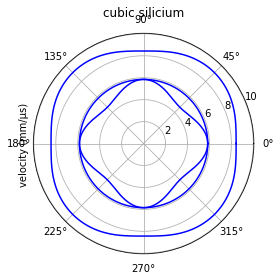

In [19]:
def from_cubic_c11_c12_c44(c11, c12, c44):
    """Makes cubic cij matrix based on the three inputs."""
    cij = np.zeros((6, 6))
    cij[:3, :3] = c12
    cij[[0, 1, 2], [0, 1, 2]] = c11  # overwrite previous cells
    cij[[3, 4, 5], [3, 4, 5]] = c44
    return cij

cij_silicium = from_cubic_c11_c12_c44(c11=165.7, c12=63.9, c44=79.6)

cijkl_silicium = to_cijkl(cij_silicium)

rho_silicum = 2.33

velocities = compute_velocities(qs, cijkl_silicium, rho_silicum)

plot_velocity(thetas, velocities, title='cubic silicium')

What if we choose another plane of rotation?

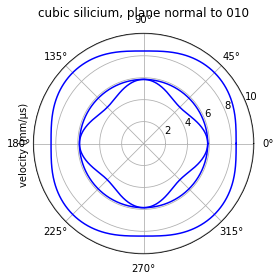

In [9]:
qs = np.c_[[np.sin(thetas), np.zeros_like(thetas), np.cos(thetas)]] 

velocities = compute_velocities(qs, cijkl_silicium, rho_silicum)

plot_velocity(thetas, velocities, title='cubic silicium, plane normal to 010')

Judging by the diagram, the XZ plane is equivalent to the XY plane.

What about rotation to a 111 normal vector? Let's use `scipy.rotation` to do crazy rotational stuff.

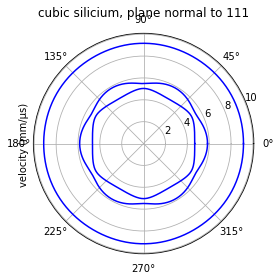

In [14]:
from scipy.spatial.transform import Rotation as R

theta1 = np.arctan(1 / np.sqrt(2))
r = R.from_euler('ZYX', [45, -np.rad2deg(theta1), 0], degrees=True)

qs = np.c_[[np.zeros_like(thetas), np.cos(thetas),  np.sin(thetas)]] 

new_qs = r.apply(qs.T).T

velocities = compute_velocities(new_qs, cijkl_silicium, rho_silicum)

plot_velocity(thetas, velocities, title='cubic silicium, plane normal to 111')

What's interesting here is that there are now six directions of identical speeds, which is a result of the crystal lattice which has six-fold symmetry around some axes.